<a href="https://colab.research.google.com/github/frabadd/ComputacionEvolutiva/blob/main/Computaci%C3%B3n_Evolutiva_Lung_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# Acceder a Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
get_file = lambda route: os.path.join('/content/drive/MyDrive/Computación Evolutiva/Prácticas', route)

# Leer el archivo con los datos
data = pd.read_csv(get_file('LungCancer.csv'))
data

Mounted at /content/drive


,Sexo,Edad,Fumador,DedosAmarillos,Ansiedad,Hipertension,EnfermedadCronica,Fatiga,Alergia,Silbidos,ConsumidorAlcohol,Tos,DificultadRespirar,DificultadTragar,DolorPecho,CancerPulmon
0,M,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,M,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,F,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,M,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,F,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,F,59,0,1,1,1,0,0,1,1,0,1,0,1,0,1
280,F,59,1,0,0,0,1,1,1,0,0,0,1,0,0,0
281,M,55,1,0,0,0,0,1,1,0,0,0,1,0,1,0
282,M,46,0,1,1,0,0,0,0,0,0,0,0,1,1,0


count    284.000000
mean      62.774648
std        8.325018
min       21.000000
25%       57.000000
50%       62.000000
75%       69.000000
max       87.000000
Name: Edad, dtype: float64


<Axes: ylabel='Frequency'>

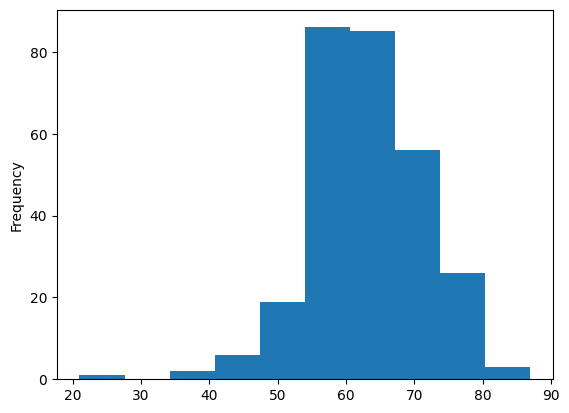

In [5]:
print(data['Edad'].describe())
data['Edad'].plot(kind='hist')

In [10]:
data['Sexo'].value_counts()

,count
Sexo,
M,148
F,136


In [17]:
for column in data.columns:
  if column != 'CancerPulmon' and column != 'Sexo':
    print(column)
    print(data[column].corr(data['CancerPulmon']))
    print()

Edad
0.09886490784965353

Fumador
0.04456874564720377

DedosAmarillos
0.18127751077868443

Ansiedad
0.1392782406556131

Hipertension
0.18894397370866936

EnfermedadCronica
0.13803895785239464

Fatiga
0.15977848130282227

Alergia
0.33602488494536314

Silbidos
0.24977176366326126

ConsumidorAlcohol
0.29438829361705465

Tos
0.24701152620435418

DificultadRespirar
0.06322131162935161

DificultadTragar
0.26257391018974297

DolorPecho
0.19324259020796564



In [ ]:
def binarize_df(df):
    b_df = df
    for column in df.columns:
        b_df = binarize_column(b_df, column)
    return b_df

def binarize_column(df, column_name):
    unique_values = df[column_name].unique()
    
    if len(unique_values) == 2:
        df[column_name] = df[column_name].map({unique_values[0]: 0, unique_values[1]: 1})
    else:
        df = bin_and_one_hot(df, column_name)

    return df


def bin_and_one_hot(df, column_name, q = 4):
    
    df[column_name] = pd.qcut(df[column_name], q=q, labels=False)  

    df_one_hot = pd.get_dummies(df[column_name], prefix=column_name)

    df_one_hot = df_one_hot.astype(int)
    
    df.drop(column_name, axis=1, inplace=True)
    
    df = pd.concat([df, df_one_hot], axis=1)
    
    return df


# Función de fitness optimizada

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Recibe la población entera como entrada y devuelve un vector con forma (len(poblacion),) con el fitness de cada individuo
def fitness_poblacion(poblacion, umbral = 0.5, metrica = 'f1'):

  poblacion = np.asarray(poblacion)
  probs = np.dot(Xtrain, poblacion.T)

  y_pred = (probs >= umbral).astype(int)
  y_true = Ytrain
  
  scores = np.empty(y_pred.shape[1])
  if metrica == 'f1':
    for i in range(y_pred.shape[1]):
      tp = np.sum((y_true == 1) & (y_pred[:,i] == 1))
    
      # False Positives (FP): y_true == 0 y y_pred == 1
      fp = np.sum((y_true == 0) & (y_pred[:,i] == 1))
      
      # False Negatives (FN): y_true == 1 y y_pred == 0
      fn = np.sum((y_true == 1) & (y_pred[:,i] == 0))
      
      # Calcular Precision y Recall
      precision = tp / (tp + fp) if (tp + fp) > 0 else 0
      recall = tp / (tp + fn) if (tp + fn) > 0 else 0
      
      # Calcular F1-score
      if precision + recall == 0:
          return 0.0
      scores[i] = 2 * (precision * recall) / (precision + recall)
    
  elif metrica == 'acc':
    for i in range(y_pred.shape[1]):
      correct_predictions = np.sum(y_true == y_pred[:,i])
    
      # Calcular el accuracy
      scores[i] = correct_predictions / len(y_true)

  return scores

# Calcula el fitness para un individuo
def fitness(individuo, umbral = 0.5, metrica = 'f1'):

  individuo = np.asarray(individuo)
  y_true = Ytrain
  probs = np.dot(Xtrain, individuo.T)
  y_pred = (probs >= umbral).astype(int)

  if metrica == 'f1':
    tp = np.sum((y_true == 1) & (y_pred == 1))
    
    # False Positives (FP): y_true == 0 y y_pred == 1
    fp = np.sum((y_true == 0) & (y_pred == 1))
    
    # False Negatives (FN): y_true == 1 y y_pred == 0
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calcular Precision y Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Calcular F1-score
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

  elif metrica == 'acc':
    return np.sum(y_true == y_pred) / len(y_true)
